# Convolutional Neural Networks (LeNet)
LeNet the first published CNNs to capture wide attention for its performance on computer vision tasks. The model was introduced by (and named for) Yann LeCun, then a researcher at AT&T Bell Labs, for the purpose of recognizing handwritten digits in images

## LeNet
At a high level, (**LeNet (LeNet-5) consists of two parts: (i) a convolutional encoder consisting of two convolutional layers; and (ii) a dense block consisting of three fully-connected layers**); The architecture is summarized in ![lenet](images/lenet.svg)

The basic units in each convolutional block are a convolutional layer, a sigmoid activation function, and a subsequent average pooling operation. Note that while ReLUs and max-pooling work better, these discoveries had not yet been made in the 1990s. Each convolutional layer uses a 5×5 kernel and a sigmoid activation function. These layers map spatially arranged inputs to a number of two-dimensional feature maps, typically increasing the number of channels. The first convolutional layer has 6 output channels, while the second has 16. Each 2×2 pooling operation (stride 2) reduces dimensionality by a factor of 4 via spatial downsampling. The convolutional block emits an output with shape given by (batch size, number of channel, height, width).

The LeNet's architecture can be represents by the figure below:

![arch](images/lenet-vert.svg)

In [1]:
from tqdm import tqdm
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

In [2]:
# model declaration
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Dataset 
As mention above, *LeNet* is the first published CNNs for the purpose of recognizing handwritten digits. The most famous dataset of handwritten digits is MNIST, luckyly *pytorch* does support us to download the dataset from the *torchvision* library.

In [3]:
def transform(is_train=True):
    transform = [
        transforms.Resize((32, 32)),
        ]
    if is_train:
        transform += [
            transforms.RandomApply([transforms.RandomAffine(
                degrees=15,
                translate=(0.1, 0.1), 
                scale=(0.9, 1.1), 
                shear=0.1
            )],p=0.6),
        ]
    
    transform += [
        transforms.ToTensor(),
    ]

    transform_function = transforms.Compose(transform)
    return transform_function

In [4]:
data_train = datasets.MNIST('./data/mnist', download=True, transform=transform())
data_test = datasets.MNIST('./data/mnist', train=False, download=True, transform=transform(is_train=False))

In [5]:
dataloaders = dict(
    train = DataLoader(data_train, batch_size=256, shuffle=True, num_workers=8),
    valid = DataLoader(data_test, batch_size=1024, shuffle=False, num_workers=8)
)

# Visuallize the dataset
Now we have dataloader for our dataset, let's visuallize it

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [15, 8]

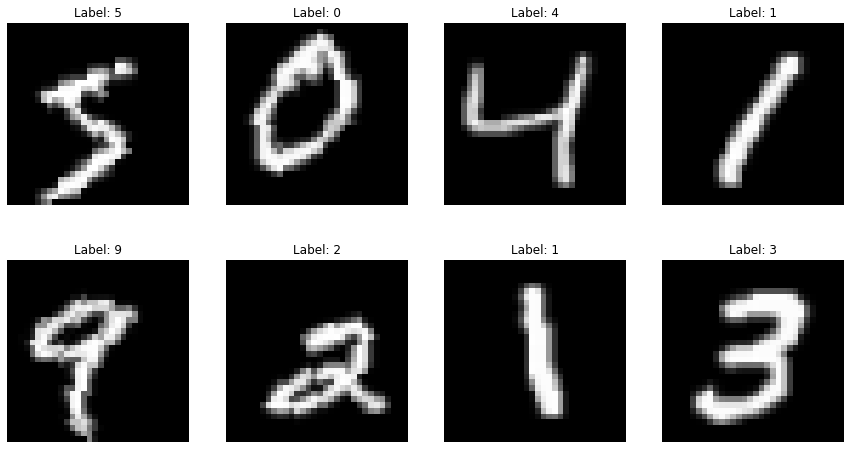

In [7]:
fig, axs = plt.subplots(2, 4)

index = 0
for i in range(2):
    for j in range(4):
        img, label = data_train[index]
        axs[i][j].imshow(img.numpy().squeeze(), cmap="gray")
        axs[i][j].title.set_text(f'Label: {label}')
        axs[i][j].axis('off')
        index += 1

# Training

In [8]:
def initWeight(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [9]:
def training(dataloader, model, loss_func, optim, epochs, device=''):
    def epochTrain():
        model.train()
        epoch_loss = 0
        for idx, (data, target) in enumerate(dataloader['train']):
            if device != '':
                data, target = data.to(device), target.to(device)

            # zero the parameter gradient
            optim.zero_grad()

            # loss function
            pred = model(data)
            loss = loss_func(pred, target)

            # update gradient
            loss.backward()
            optim.step()

            # statistic
            epoch_loss += loss.item()
        
        total = epoch_loss/len(dataloader)
        return total

    def epochValid():
        model.eval()
        epoch_loss, epoch_acc, epoch_count = 0,0,0
        with torch.no_grad():
            for idx, (data, target) in enumerate(dataloader['valid']):
                if device != '':
                    data, target = data.to(device), target.to(device)

                pred = model(data)
                loss = loss_func(pred, target)

                epoch_loss += loss.item()
                epoch_acc += torch.sum(torch.argmax(pred, dim=1) == target)
                epoch_count += target.shape[0]
            
            total_loss = epoch_loss/(len(dataloader['valid']))
            total_acc = epoch_acc/epoch_count
            return total_loss, total_acc
    
    train_losses, valid_losses, valid_accuracy = [], [], []
    progess_bar = tqdm(range(epochs), total=epochs)

    for epoch in progess_bar:
        #append current train epoch's loss score
        train_losses.append(epochTrain())
        
        #append current valid's loss and error
        valid_loss, valid_acc = epochValid()
        valid_losses.append(valid_loss)
        valid_accuracy.append(valid_acc)

        #print progess bar
        progess_bar.set_description(f'Valid loss: {valid_loss:.3f} | Accuracy: {100*valid_acc:.3f}% ')
    
    return train_losses, valid_losses, valid_accuracy

In [10]:
device = {'cuda:0' if torch.cuda.is_available() else 'cpu'}

In [11]:
# init model 
# model = Net().to(device) # uncomment this line if train on gpu
model = Net()
model.apply(initWeight)

# loss function
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [12]:
#training function
train_losses, valid_losses, valid_accuracy = training(dataloader=dataloaders, model=model, loss_func=loss_func, optim=optimizer, epochs=5)

Valid loss: 0.039 | Accuracy: 98.720% : 100%|██████████| 5/5 [02:18<00:00, 27.63s/it]


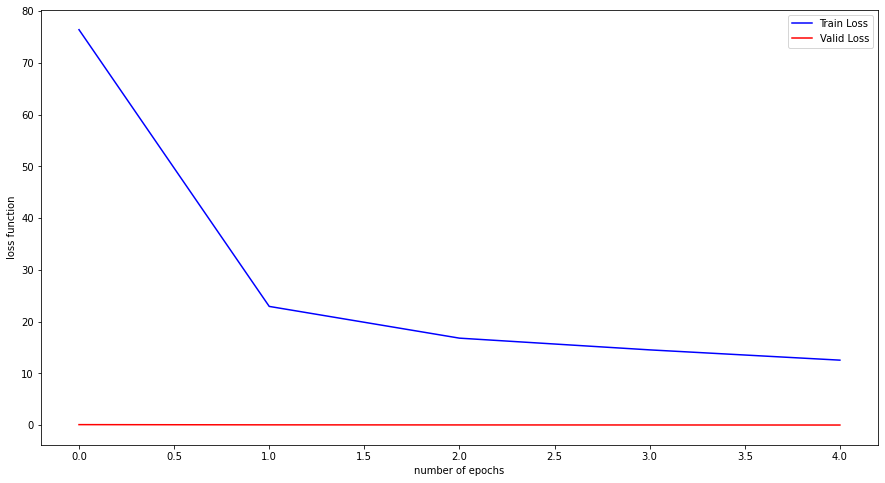

In [13]:
fig = plt.figure()
plt.plot(range(5), train_losses, color='blue')
plt.plot(range(5), valid_losses, color='red')
plt.legend(['Train Loss', 'Valid Loss'], loc='upper right')
plt.xlabel('number of epochs')
plt.ylabel('loss function')
plt.show()